In [1]:
import pandas as pd
import sys
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from konlpy.tag import Okt
import tensorflow.compat.v1 as tf
from tensorflow import keras
%matplotlib inline

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [2]:
data = pd.read_csv("train_data_ver1.csv")

In [3]:
keyword = pd.read_csv("keyword.csv")

In [4]:
data['label'] = data['label'].fillna(1)


In [5]:
data['label'] = data['label'].astype(int)

data['data'] = data['data'].fillna("1")


In [6]:
for key in keyword['keyword']:
#    data["data"] = data['data'].apply(lambda x:1 if key in x else 0)
    data.loc[(data['data'].str.contains(key)), 'label'] = 0

### conv9, pooling9
### drop out rate =  0.2
###  split 비율 = 0.1 , epoc = 10
# train_ acc = 0.93503606, step = 10130, loss = 0.6403086
#Experiment elapsed time: 290.422398 seconds
# eval_ acc = 0.946027, step = 10130, loss = 0.5208163

# 데이터 불러오기

In [7]:
DATA_IN_PATH = 'C:\\Users\\박다원\\Documents\\test\\test\\'
train_data  = pd.read_csv(DATA_IN_PATH+'train_data_ver1.csv')

In [8]:
train_data .head()

,id,data,label
0,1,윗분이 말한것도 맞는데 지금 바텀 문제되는게 상대 미드 좀만 커도 8렙찍고 내려와서...,0
1,2,레벨링차이가 크긴큼 ㅋㅋ 2명이서 먹는 경험치가 너프되서 그런가윗라인이 초반에 솔킬...,0
2,3,블라인드 된 코멘트입니다. [내용보기]아니 바텀 ㅈ망겜인데 왜 바텀을 상향시키냐고미...,0
3,4,블라인드 된 코멘트입니다. [내용보기]내가 시즌2부터 다이아 계속달면서 느낀건시즌2...,0
4,5,라이엇은 상체겜이라는데 라이앳이 병신이였네,0


In [9]:
train_data.shape

(20007, 3)

In [10]:
train_data.dtypes

id        int64
data     object
label     int64
dtype: object

In [11]:
train_data['label'] = train_data['label'].astype(str).astype(int)

# 각 라벨의 분포를 확인

### 현재 데이터가 50%씩 골고루 분포됨을 확인

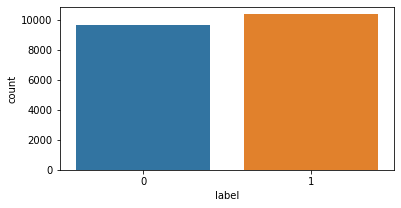

In [12]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_data ['label'])

# 데이터 전처리

### 학습 데이터와 검증 데이터를 train_test_spit 함수를 활용해 나눈다.

In [13]:
#train_data = pd.read_csv(DATA_IN_PATH + 'sds_train_data.csv')


# train set, eval set 나누기
from sklearn.model_selection import train_test_split
train_input, eval_input= train_test_split(train_data, test_size = 0.1, random_state = 1234)

In [14]:
print(train_input.isnull())

          id   data  label
19671  False  False  False
2609   False  False  False
4938   False  False  False
16451  False  False  False
19913  False  False  False
...      ...    ...    ...
8222   False  False  False
9449   False  False  False
8471   False  False  False
17048  False  False  False
1318   False  False  False

[18006 rows x 3 columns]


### 데이터 분석 과정

In [15]:
train_lenght = train_input['data'].astype(str).apply(len)
train_lenght.head()

19671     44
2609      22
4938       6
16451     88
19913    172
Name: data, dtype: int64

Text(0, 0.5, 'Number of data')

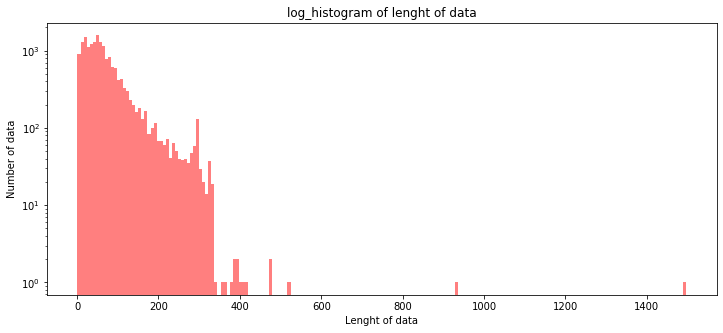

In [16]:
#그래프에 대한 이미지 크기 선언
plt.figure(figsize=(12,5))
plt.hist(train_lenght, bins =200, alpha=0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy='clip')
plt.title('log_histogram of lenght of data')
plt.xlabel('Lenght of data')
plt.ylabel('Number of data')

**위를 보면 거의 길이가 200 이하인 것을 볼 수 있다.
그중에 거의 100개 이하로 되어있다.**

**실제 통계값으로 계산하면,,**

In [17]:
print('데이타 길이 최댓값 : {}'.format(np.max(train_lenght)))
print('데이타 길이 최솟값 : {}'.format(np.min(train_lenght)))
print('데이타 길이 평균값 : {}'.format(np.mean(train_lenght)))
print('데이타 길이 표준편차 : {}'.format(np.std(train_lenght)))
print('데이타 길이 중간값 : {}'.format(np.median(train_lenght)))

데이타 길이 최댓값 : 1497
데이타 길이 최솟값 : 1
데이타 길이 평균값 : 70.14023103409974
데이타 길이 표준편차 : 62.594274967659956
데이타 길이 중간값 : 54.0


**데이터 길이의 최대값이 1497 이고, 평균적인 길이는 70 이다.**

**이번엔 데이터 단어 수를 확인해 보자**

Text(0, 0.5, 'Number of data')

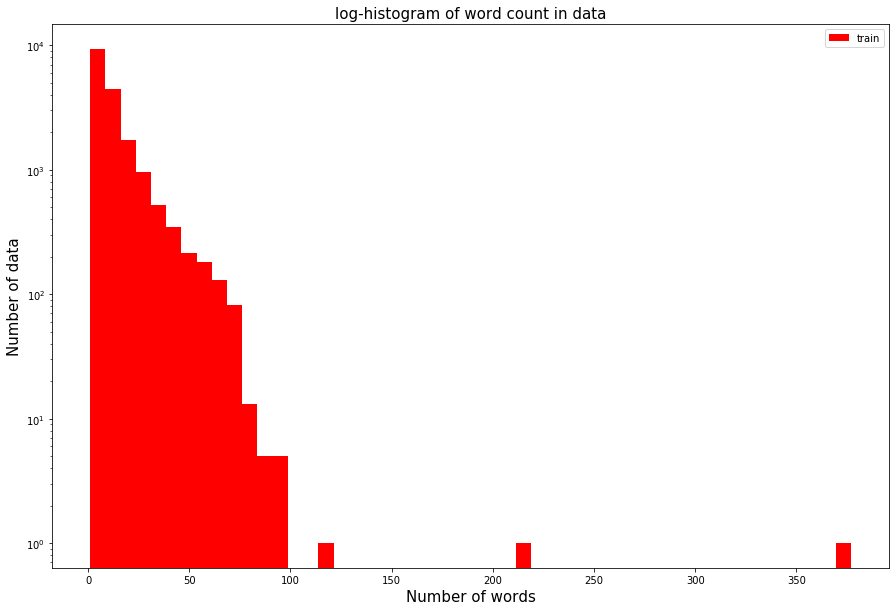

In [18]:
train_word_counts = train_input['data'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(15,10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('log-histogram of word count in data', fontsize= 15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of data', fontsize = 15)

In [19]:
print('데이타 단어 개수 최댓값 : {}'.format(np.max(train_word_counts )))
print('데이타 단어 개수 최솟값 : {}'.format(np.min(train_word_counts )))
print('데이타 단어 개수 평균값 : {}'.format(np.mean(train_word_counts )))
print('데이타 단어 개수 표준편차 : {}'.format(np.std(train_word_counts )))
print('데이타 단어 개수 중간값 : {}'.format(np.median(train_word_counts )))

데이타 단어 개수 최댓값 : 377
데이타 단어 개수 최솟값 : 1
데이타 단어 개수 평균값 : 12.551205153837609
데이타 단어 개수 표준편차 : 13.241970712091677
데이타 단어 개수 중간값 : 8.0


**결과를 보면 평균 12~13개의 단어 개수를 가지고 있고 중간값의 경우는 8개의 단어를 가지고 있다.**

# okt 객체를 사용해 형태소를 분석한다. so, 어간 추출을 사용해 어간이 추출된 단어로 나눈다

In [20]:
okt = Okt()

### 한글을 제외한 모든 문자 제거, 형태소 토크나이징, 불용어 제거 순으로 진행되는 함수

In [21]:
def preprocessing(review, okt, remove_stopwords, stop_words=[]):
    #함수의 인자는
    #review : 전처리할 텍스트
    #okt : okt객체를 반복적으로 생성하지 않구 미리 만들어 인자로 받음
    #remove_stopword : 불용어를 제거할지 여부 선택
    
    # 정규 표현식을 활용해 한글 문자가 아닌 것들을 모두 제거
    #1.한글 및 공백 제외한 문자 모두 제거
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    
    #2. okt 객체를 활용해 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem= True)
    
    if remove_stopwords:
        #불용어 제거 (선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
        
    return word_review

In [22]:
stop_words= ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
clean_train_review = []

for review in train_input['data']:
    #비어 있는 데이터에서 멈추지 않도록 문자열인 경우만 진행
    if type(review)==str:
        clean_train_review.append(preprocessing(review,okt,True,stop_words))
    else :
        clean_train_review.append([]) #string이 아니면 비어있는 값 추가

In [23]:
clean_test_review=[]

for review in eval_input['data']:
    #비어 있는 데이터에서 멈추지 않도록 문자열인 경우만 진행
    if type(review)==str:
        clean_test_review.append(preprocessing(review,okt,True,stop_words))
    else :
        clean_test_review.append([]) #string이 아니면 비어있는 값 추가

### 패딩 처리 남음

#### 패딩처리를 할때, 최대 길이를 데이터 분석 과정에서 단어의 평균 개수인 대략 3개로 하였다.

In [24]:
tokenizer = Tokenizer()
# 단어 인덱스를 구축합니다.
tokenizer.fit_on_texts(clean_train_review)
# 문자열을 정수 인덱스의 리스트로 변환합니다.
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index #단어 사전 형태

MAX_SEQUENCE_LENGHT = 13

#학습 데이터를 벡터화
train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGHT, padding='post')
#학습 데이터의 라벨
train_labels = np.array(train_input['label'])

#평가 데이터를 벡터화
eval_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGHT, padding='post')
#평가 데이터의 라벨
eval_labels = np.array(eval_input['label'])

In [25]:
TRAIN_INPUT_DATA = 'sds_train_input.npy'
TRAIN_LABEL_DATA = 'sds_train_label.npy'
TEST_INPUT_DATA = 'sds_test_input.npy'
TEST_LABEL_DATA = 'sds_test_label.npy'
DATA_CONFIGS= 'data_configs.json'

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size']= len(word_vocab)+1
import json
json = json.dumps(tokenizer.word_index)
f3 = open("wordIndex.json", "w")
f3.write(json)
f3.close()
import os
# 저장하는 디렉터리가 존재하지 않으면 생성
if not os.path.exists( DATA_IN_PATH):
    os.makedirs( DATA_IN_PATH)
    
#전처리된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'),train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'),train_labels)
#전처리된 평가 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'),eval_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'),eval_labels)
    


In [26]:
print(len(word_vocab))
train_inputs.shape

20631


(18006, 13)

In [27]:
train_labels.shape

(18006,)

In [28]:
eval_inputs.shape

(2001, 13)

In [29]:
eval_labels.shape

(2001,)

# 모델링 과정에서 사용할 수 있도록 저장

In [30]:
TRAIN_INPUT_DATA = 'sds_train_input.npy'
TRAIN_LABEL_DATA = 'sds_train_label.npy'
TEST_INPUT_DATA = 'sds_test_input.npy'
TEST_LABEL_DATA = 'sds_test_label.npy'
DATA_CONFIGS= 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size']= len(word_vocab)+1

import os
# 저장하는 디렉터리가 존재하지 않으면 생성
if not os.path.exists( DATA_IN_PATH):
    os.makedirs( DATA_IN_PATH)
    
#전처리된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'),train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'),train_labels)
#전처리된 평가 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'),eval_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'),eval_labels)
import json
json = json.dumps(tokenizer.word_index)
f3 = open("wordIndex.json", "w")
f3.write(json)
f3.close()

# 모델링

In [31]:
input_data = train_inputs
label_data = train_labels


In [32]:
input_data = input_data.transpose()

In [33]:
input_data.shape

(13, 18006)

In [34]:
input_data = input_data.transpose()

In [35]:
input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size = 0.1, random_state = 1234)

# 데이터 입력 함수

In [36]:
def mapping_fn(X, Y):
    input, label = {'x': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=len(input_train))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    dataset = dataset.repeat(count=NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()
    
    
    return iterator.get_next()

def eval_input_fn():
    dataset1 = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
    dataset1 = dataset1.shuffle(buffer_size=len(input_eval))
    dataset1 = dataset1.batch(BATCH_SIZE)
    dataset1 = dataset1.map(mapping_fn)
    iterator = dataset1.make_one_shot_iterator()
   # batched_dataset = dataset.test(flags_obj.data_dir).batch(flags_obj.batch_size)
    #return batched_dataset.__iter__()
    return iterator.get_next()


# 모델 함수

In [37]:
def model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    #embedding layer선언
    embedding_layer = tf.keras.layers.Embedding(
                    vocab_size+1,
                    embedding_size)(features['x'])
    #embedding layer에 대한 output에 대해 dropout을 취함
    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
    # filter = 정추, 출력 공간의 차원 ( 컨볼루션의 출력 필터 수)
    conv1 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=3,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool1 = tf.keras.layers.GlobalMaxPool1D()(conv1)
        
        
    conv2 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=4,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool2 = tf.keras.layers.GlobalMaxPool1D()(conv2)
    
    
    conv3 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=5,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool3 = tf.keras.layers.GlobalMaxPool1D()(conv3)
    
    conv4 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=6,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool4 = tf.keras.layers.GlobalMaxPool1D()(conv4)
    
    conv5 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=5,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool5 = tf.keras.layers.GlobalMaxPool1D()(conv5)
    conv6 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=7,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool6 = tf.keras.layers.GlobalMaxPool1D()(conv6)
    conv7 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=4,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool7 = tf.keras.layers.GlobalMaxPool1D()(conv7)
    conv8 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=3,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool8 = tf.keras.layers.GlobalMaxPool1D()(conv8)
    conv9 = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=6,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
    pool9 = tf.keras.layers.GlobalMaxPool1D()(conv9)
    
    
    
    concat = keras.layers.concatenate([pool1, pool2, pool3, pool4, pool5, pool6, pool7, pool8, pool9]) #모아주기
  
   

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(concat)   
    #u nits = 출력 공간의 양의 정수, 차원.
    # activation = 사용할 활성화 기능,

    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

### 하이퍼파라미터 정의

In [38]:
BATCH_SIZE=16
NUM_EPOCHS = 10
#ocab_size = preproconfigs['vocab_size']
embedding_size = 128
vocab_size = len(word_vocab)+1

 # 모델 학습
 
 ### 에스티메이터 객채를 정의한 후 학습 시켜본다.

In [39]:
est = tf.estimator.Estimator(model_fn, model_dir="data_out/checkpoint/cnn_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'data_out/checkpoint/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [40]:
from datetime import datetime
time_start = datetime.utcnow()
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

est.train(train_input_fn)


time_end = datetime.utcnow()
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))







Experiment started at 10:28:03
.......................................
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into data_out/checkpoint/cnn_model\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners a

INFO:tensorflow:global_step/sec: 20.6737
INFO:tensorflow:loss = 2.4497598e-05, step = 6500 (4.837 sec)
INFO:tensorflow:global_step/sec: 19.8118
INFO:tensorflow:loss = 7.206864e-07, step = 6600 (5.048 sec)
INFO:tensorflow:global_step/sec: 20.9065
INFO:tensorflow:loss = 5.233322e-06, step = 6700 (4.781 sec)
INFO:tensorflow:global_step/sec: 16.2904
INFO:tensorflow:loss = 0.00018470781, step = 6800 (6.142 sec)
INFO:tensorflow:global_step/sec: 16.309
INFO:tensorflow:loss = 0.0029991746, step = 6900 (6.131 sec)
INFO:tensorflow:global_step/sec: 13.6437
INFO:tensorflow:loss = 0.14773114, step = 7000 (7.331 sec)
INFO:tensorflow:global_step/sec: 18.024
INFO:tensorflow:loss = 1.5990048e-05, step = 7100 (5.545 sec)
INFO:tensorflow:global_step/sec: 18.606
INFO:tensorflow:loss = 2.5782824e-06, step = 7200 (5.375 sec)
INFO:tensorflow:global_step/sec: 16.5158
INFO:tensorflow:loss = 9.1984875e-06, step = 7300 (6.055 sec)
INFO:tensorflow:global_step/sec: 17.2251
INFO:tensorflow:loss = 4.687578e-06, step

# 모델 검증

In [41]:
label_data .shape

(18006,)

In [42]:
valid = est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-19T19:37:08Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data_out/checkpoint/cnn_model\model.ckpt-10130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.62938s
INFO:tensorflow:Finished evaluation at 2020-06-19-19:37:09
INFO:tensorflow:Saving dict for global step 10130: acc = 0.9255969, global_step = 10130, loss = 0.58093894
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10130: data_out/checkpoint/cnn_model\model.ckpt-10130


# 모델 평가

In [43]:
INPUT_TEST_DATA = 'sds_test_input.npy'
LABEL_TEST_DATA = 'sds_test_label.npy'

test_input_data = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
print(type(test_input_data))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))
print(type(test_label_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [44]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_label_data))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [45]:
predict = est.evaluate(test_input_fn) 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-19T19:37:10Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data_out/checkpoint/cnn_model\model.ckpt-10130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.64930s
INFO:tensorflow:Finished evaluation at 2020-06-19-19:37:10
INFO:tensorflow:Saving dict for global step 10130: acc = 0.93753123, global_step = 10130, loss = 0.47468576
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10130: data_out/checkpoint/cnn_model\model.ckpt-10130
